In [24]:
import numpy as np
import special_plots

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.utils import R_lasso
from mrashpen.utils import R_trendfilter
from gradvi.inference import LinearRegression
from gradvi.normal_means import NormalMeansFromPosterior
from gradvi.tests import toy_priors
from gradvi.tests import toy_data
from gradvi.optimize import moving_average as gvma

Signal-to-noise ratio: 0.009


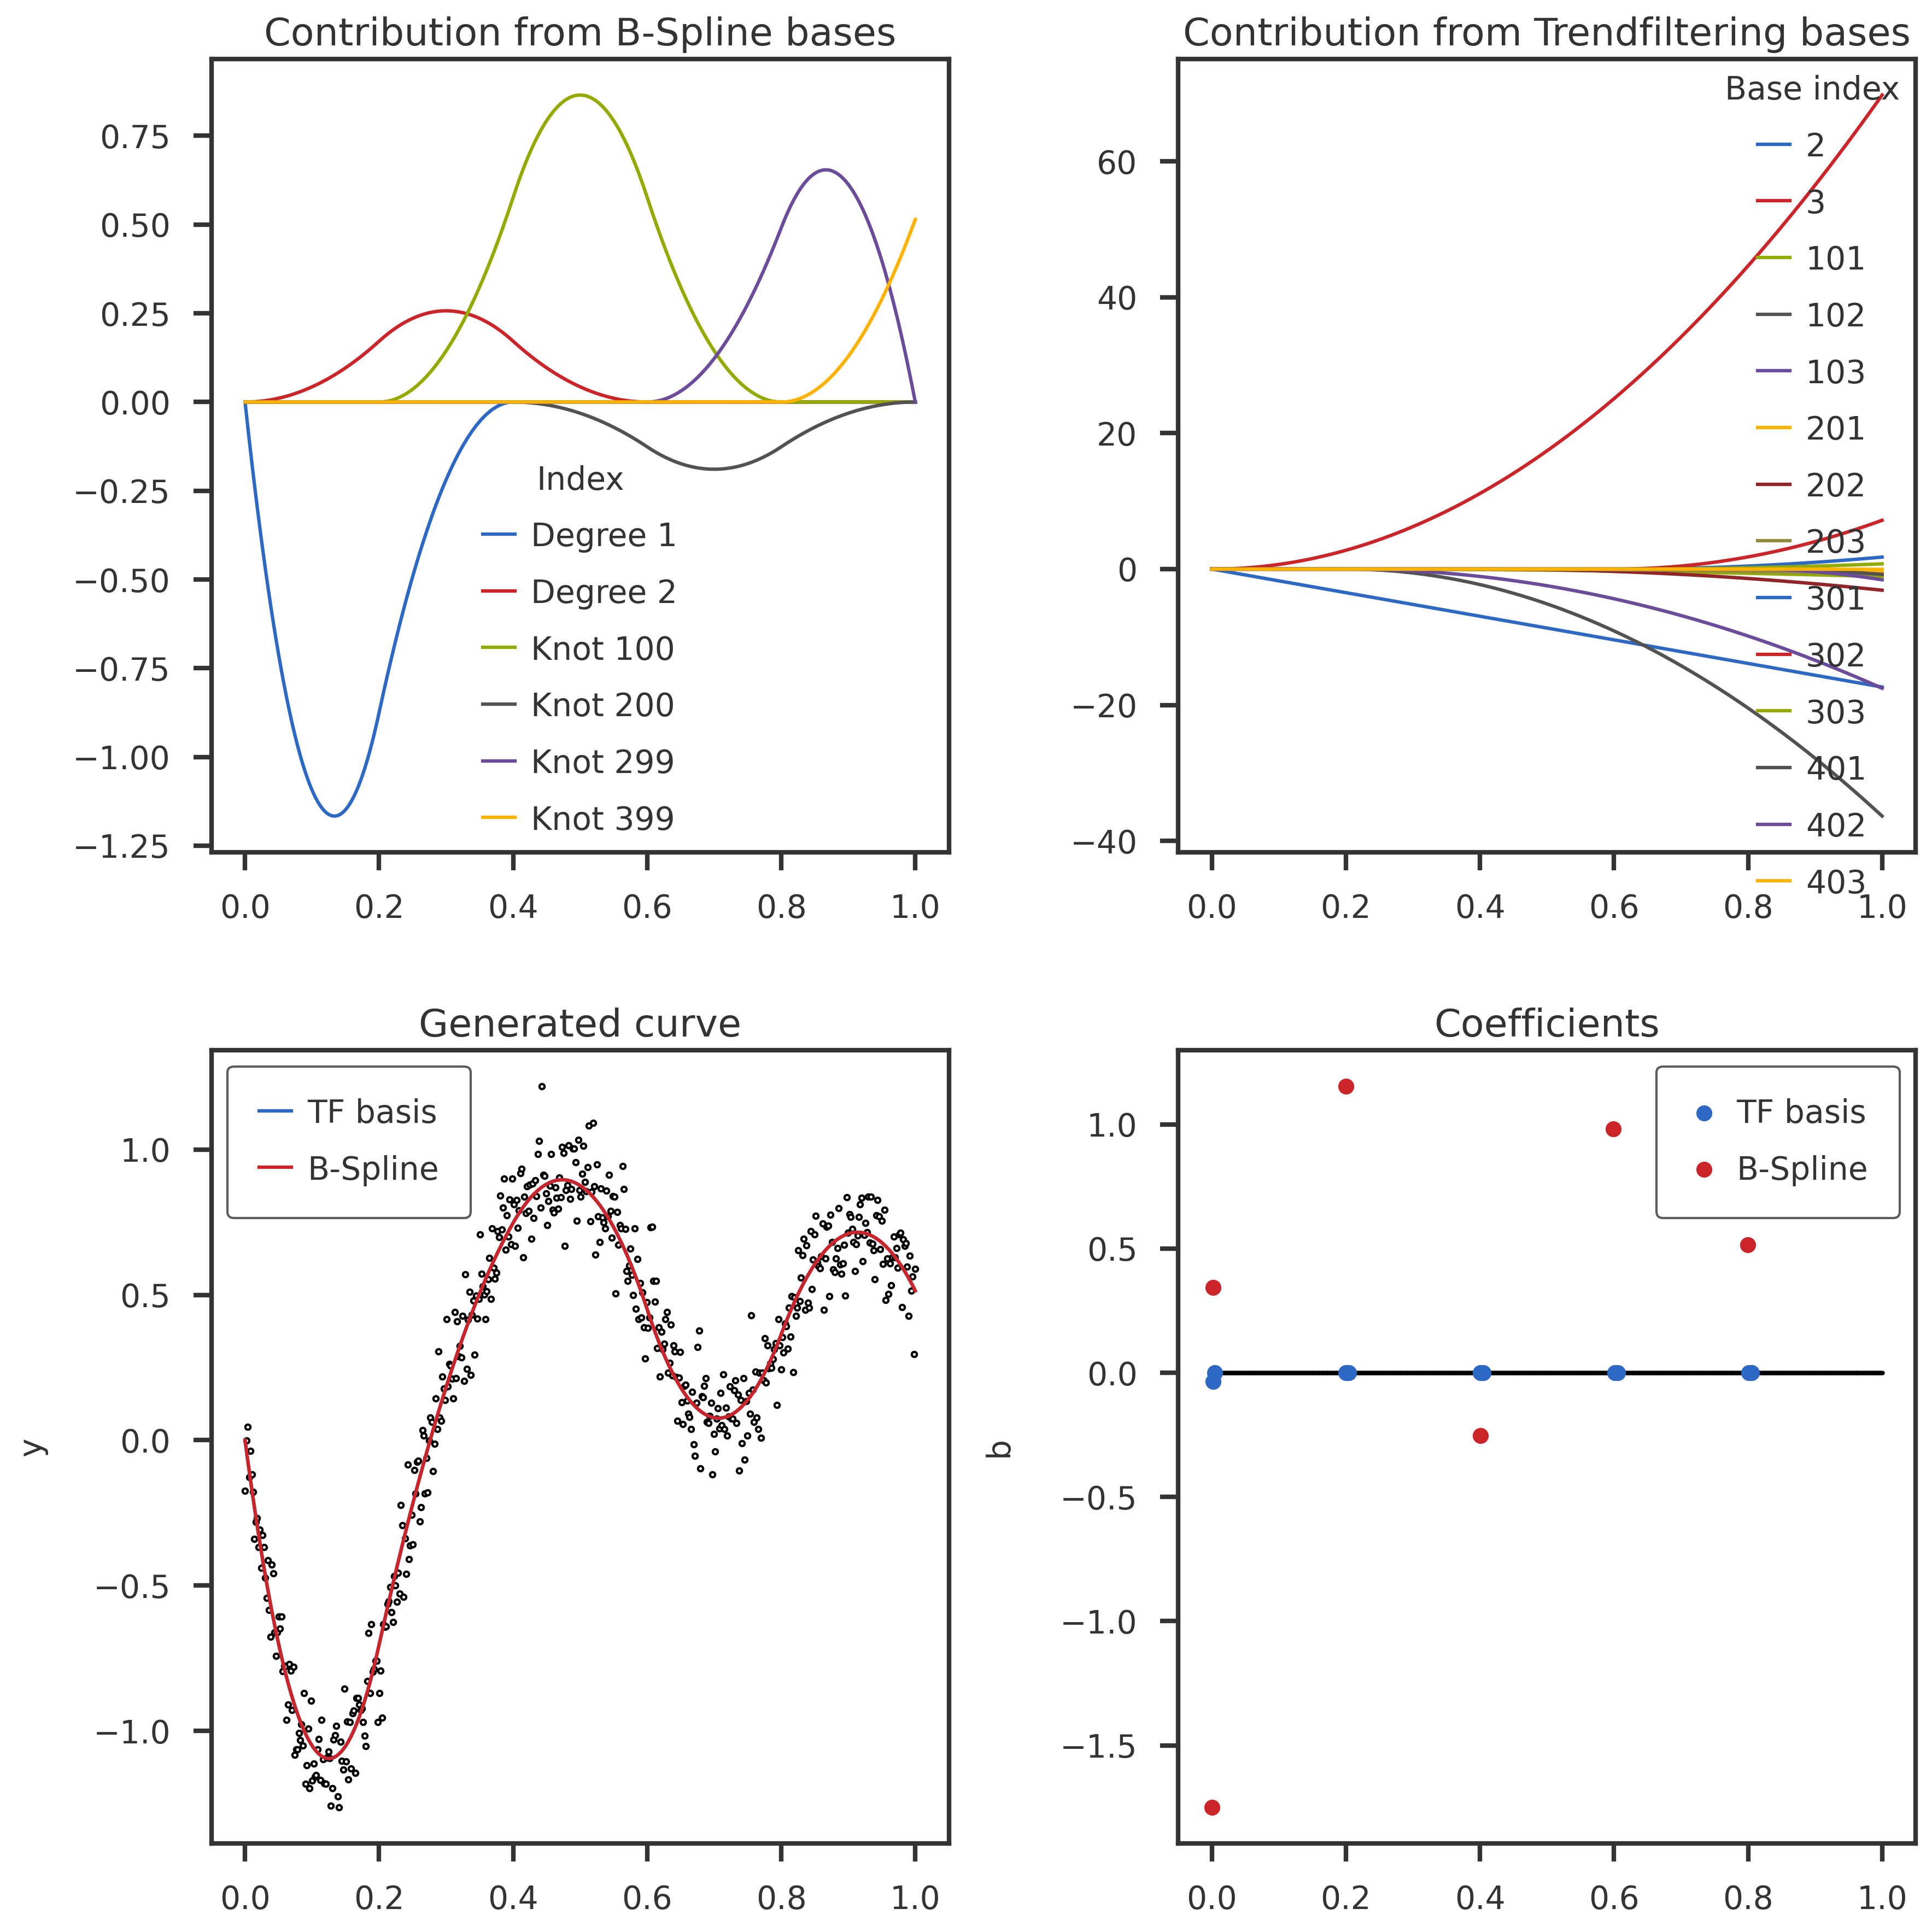

In [2]:
n = 500
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 4
degree = 2
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                                         signal = "fixed", bfix = bfix,
                                         seed = 100, include_intercept = include_intercept,
                                         get_bsplines = True, eps = 1e-8)

print(f"Signal-to-noise ratio: {data.snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
special_plots.plot_data_from_bspline(axlist, data.x, data.y, knots, data.degree, 
                                     data.bspline_bases, data.bspline_beta, 
                                     data.H, data.btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [3]:
np.allclose(data.btrue, np.dot(data.Hinv, data.ytrue))

True

In [4]:
data.degree

2

In [5]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = data.degree)
tf_bhat  = np.dot(data.Hinv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [6]:
np.allclose(tf_y, np.dot(data.H, tf_bhat))

True

In [7]:
'''
GradVI Trendfiltering
'''
def fun1(params, y, A, prior, sj2, s2, dj, jac = True):
    n = y.shape[0]
    k = prior.k
    x = params[:n]
    a = params[n:]
    prior.update_wmod(a)
    
    r = y - x
    rTr = np.dot(r, r)
    
    #sj2 = s2 / dj
    b = np.dot(A, x)
    nm = NormalMeansFromPosterior(b, prior, sj2, scale = s2, d = dj, method = 'newton')
    Pb, dPdb, dPdw, dPds2 = nm.penalty_operator(jac = True)
    
    h = (0.5 * rTr / s2) + np.sum(Pb)
    #h = np.sum(Pb)
    if jac:
        dhdx = - r / s2 + np.dot(A.T, dPdb)
        #dhdx = np.dot(A.T, dPdb)
        dhdw  = np.sum(dPdw, axis = 0)
        dhda  = prior.wmod_grad(dhdw)
        return h, np.concatenate((dhdx, dhda))
    return h

def fun2(x, A, prior, sj2, s2, dj, jac = True):
    y = np.dot(A, x)
    nm = NormalMeansFromPosterior(y, prior, sj2, scale = s2, d = dj, method = 'newton')
    hj, dhdy, _, _ = nm.penalty_operator(jac = True)
    h = np.sum(hj)
    if jac:
        dhdx = np.dot(A.T, dhdy)
        return h, dhdx
    return h

In [8]:
prior = toy_priors.get_ash_scaled(k = 10, sparsity = None, skbase = 2)

dj = np.sum(np.square(data.H), axis = 0)
s2 = np.var(data.y - tf_y)
sj2 = s2 / dj
mu = tf_y.copy()
#obj, dhdmu = fun2(mu, Hinv, prior, sj2, s2, dj, jac = True)
#obj, dhdmu = fun1(mu, y, Hinv, prior, sj2, s2, dj, jac = True)

In [9]:
vars(prior)

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.07177346, 0.14869835, 0.23114441, 0.31950791,
        0.41421356, 0.51571657, 0.62450479, 0.74110113, 0.86606598]),
 'w': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'w_init': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod_init': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'is_scaled': True,
 'normal_means': gradvi.normal_means.nm_ash.NMAsh}

In [29]:
from scipy import optimize as sp_optimize

#y_init = gvma.moving_average(data.y)
y_init = tf_y.copy()

initparams = np.concatenate((y_init, prior.wmod_init))
opt_min = sp_optimize.minimize(fun1, 
            initparams,
            args = (data.y, data.Hinv, prior, sj2, s2, dj),
            method = 'l-bfgs-b', 
            jac = True,
            #options = {'disp': True, 'maxiter': 10, 'return_all': True}
            options = {'disp':True, 'maxiter': 1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.99925D+03    |proj g|=  7.95514D+07
2022-11-09 11:55:22,934 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.


 This problem is unconstrained.


2022-11-09 11:55:23,100 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,264 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,426 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,556 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,712 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,849 | gradvi.normal_means.normal_means_from_posterior | ERROR   | Inversion using newton method did not converge. Trying trisection method.
2022-11-09 11:55:23,990 | gradvi.normal_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    2    f= -4.99975D+03    |proj g|=  2.84019D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  510      2     29      1     0     0   2.840D+08  -5.000D+03
  F =  -4999.7535686135761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [30]:
vars(prior)

{'smbase': 2.718281828459045,
 'sk': array([0.        , 0.07177346, 0.14869835, 0.23114441, 0.31950791,
        0.41421356, 0.51571657, 0.62450479, 0.74110113, 0.86606598]),
 'w': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'w_init': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 'wmod_init': array([-2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499,
        -2.30258499, -2.30258499, -2.30258499, -2.30258499, -2.30258499]),
 'is_scaled': True,
 'normal_means': gradvi.normal_means.nm_ash.NMAsh}

In [31]:
ypred = opt_min.x[:mu.shape[0]]
bhat  = np.dot(data.Hinv, ypred)

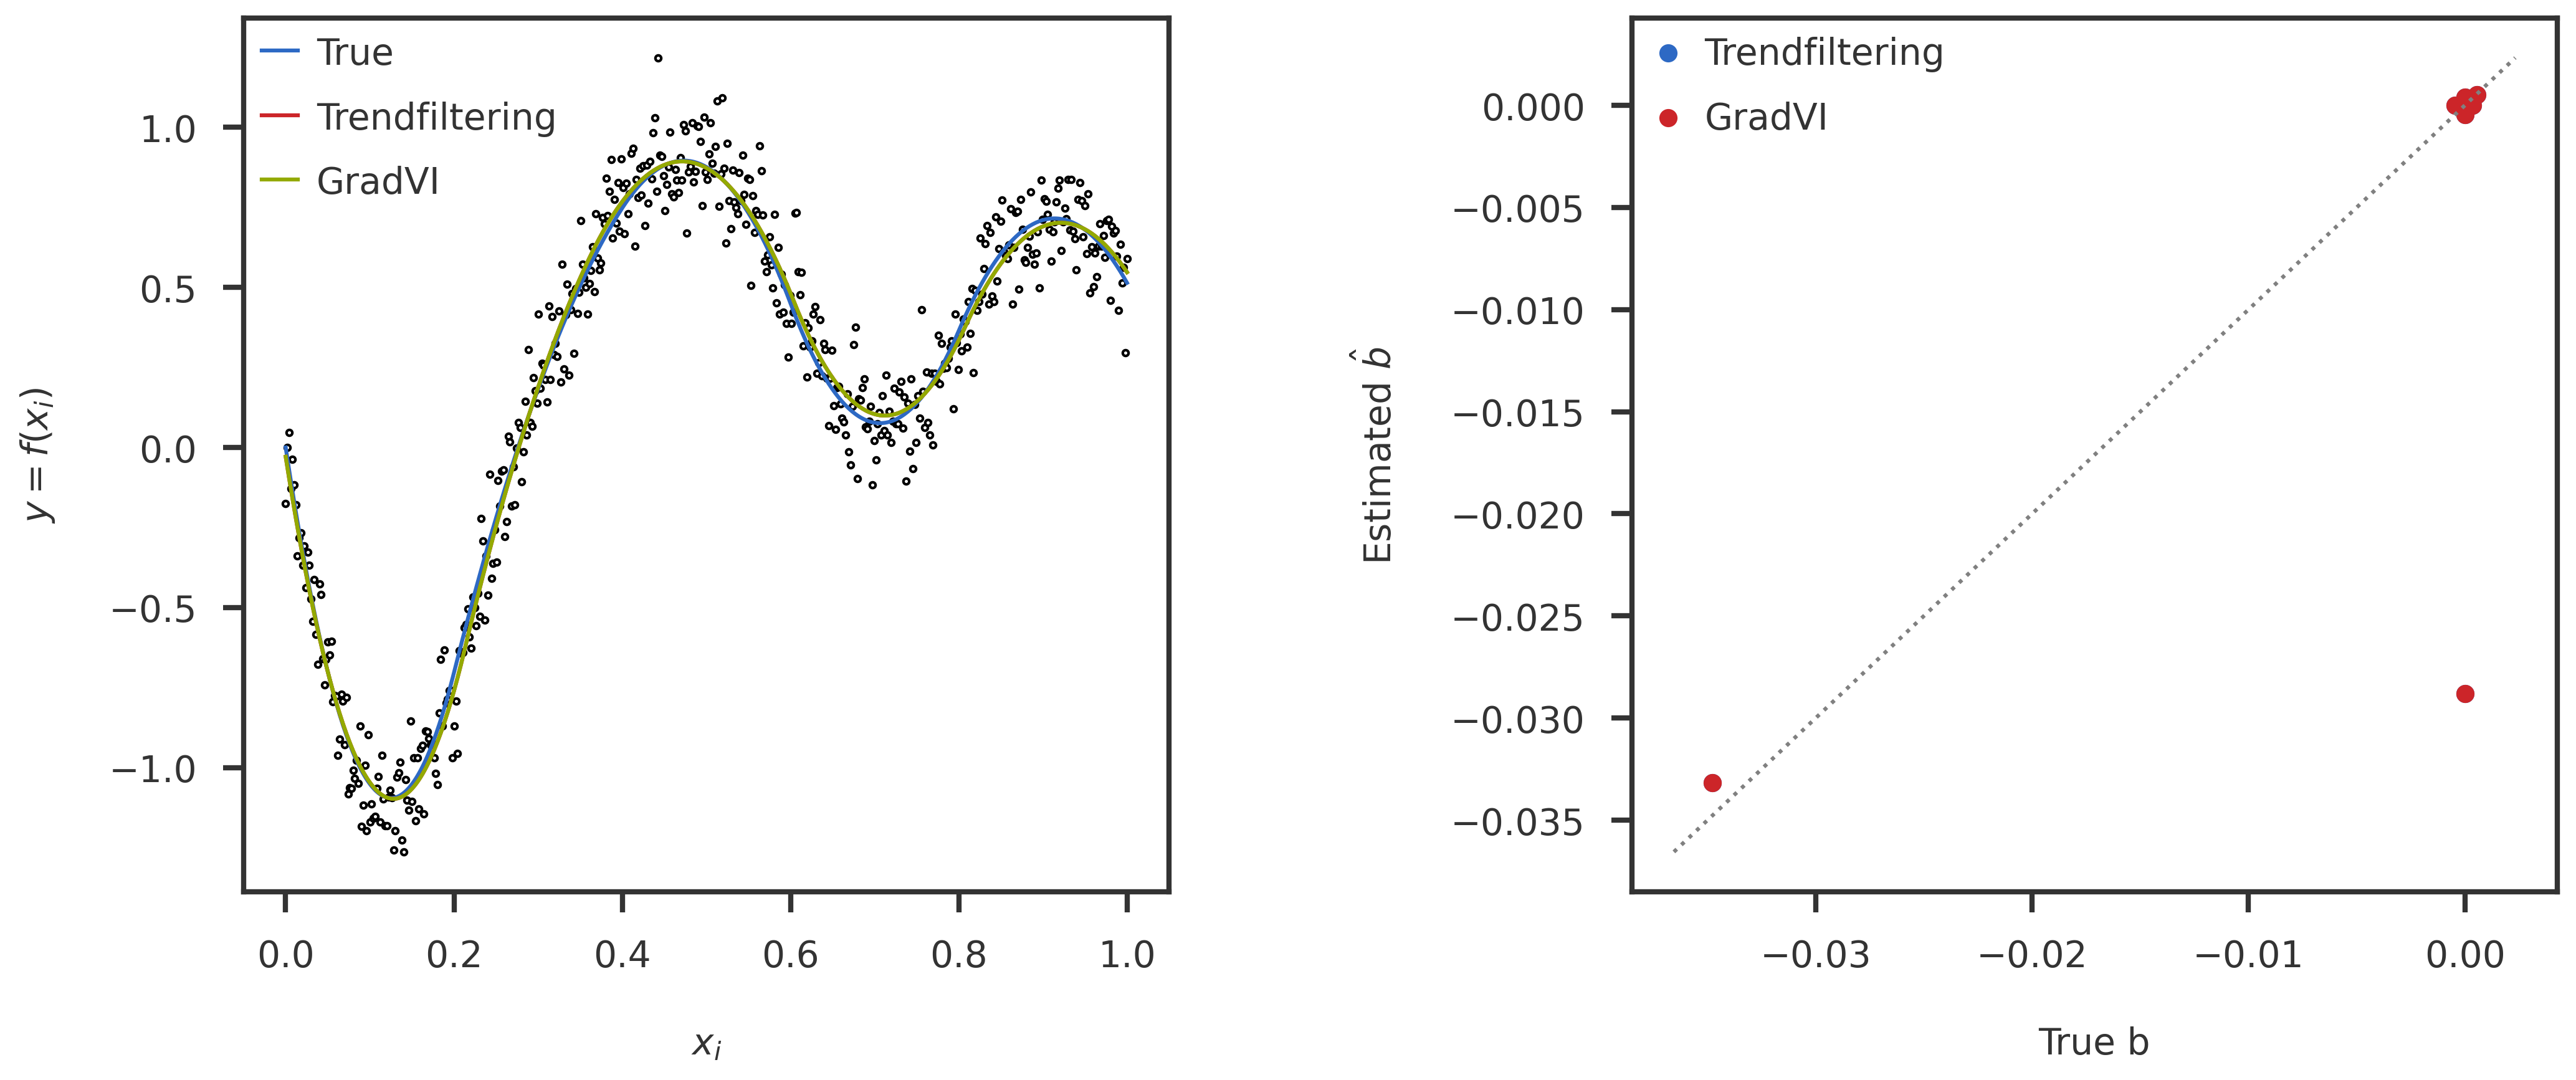

In [32]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, data.y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, data.ytrue, label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, ypred, label = "GradVI")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(data.btrue, tf_bhat, label = "Trendfiltering")
ax2.scatter(data.btrue, bhat, label = "GradVI")

ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()

mpl_utils.plot_diag(ax2)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()